# Train model using the fastai library

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Setup

### Import packages

In [96]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import scipy.io.wavfile
import torch
from fastai.vision import *
from fastai.metrics import error_rate

import IPython.display as ipd
from tqdm import tqdm_notebook

### Instantiate ImageDataBunch

In [3]:
pat = r'/(\w+)_\d+.jpg'

In [4]:
path_img = "../mfc_dataset"
fnames = sorted(get_image_files(path_img))
np.random.seed(42)
np.random.shuffle(fnames)
fnames[:5]

[PosixPath('../mfc_dataset/female_3075.jpg'),
 PosixPath('../mfc_dataset/male_3161.jpg'),
 PosixPath('../mfc_dataset/male_4055.jpg'),
 PosixPath('../mfc_dataset/male_5550.jpg'),
 PosixPath('../mfc_dataset/female_3396.jpg')]

In [5]:
data = ImageDataBunch.from_name_re(
    path_img, fnames, pat, size=224, bs=64, valid_pct=0.2, seed=42
).normalize(imagenet_stats)

For more information on batch size selection, see https://forums.fast.ai/t/how-to-check-your-pytorch-keras-is-using-the-gpu/7232/3.

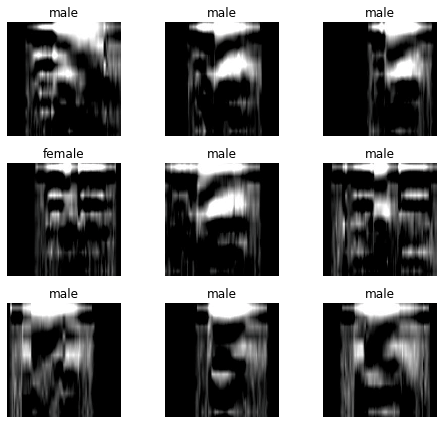

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)
len(data.classes),data.c

['female', 'male']


(2, 2)

## Train ResNet34

### Transfer learning step 1: only re-train the classifier

Instantiate a learner using data, model and metric:

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

**Note**: Since the model is already trained, you can now directly jump to "Evaluate model" to avoid retraining the model.

Verify the availability of GPU(s):

In [9]:
torch.cuda.is_available()

True

Find a good learning rate: (https://docs.fast.ai/callbacks.lr_finder.html)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


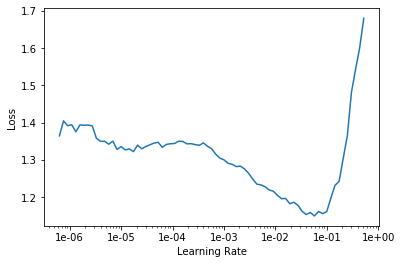

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(2, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.235953,0.149880,0.059833,02:59
1,0.117766,0.091652,0.035167,02:58


Our model is pretty accurate after only 2 epochs.

### Transfer learning step 2: re-train the entire model

After retraining the classifier, let's also train the convolutional layers.

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.048189,0.028704,0.010667,04:17


<div style="text-align: justify">
In the context of this dataset, unfreezing and retraining the entire model sometimes do not increase its performance - but sometimes it does. For this reason, I left it here. 
</div>

In [16]:
learn.export()